In [6]:
import operator
from pprint import pprint
import itertools
import re

from SolrClient import SolrClient

import gensim
from gensim.models import CoherenceModel, LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim import matutils

import pyLDAvis.gensim

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from treetagger import TreeTagger

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/media/discoD/anaconda3/lib/python3.6/site-packages/nltk/decorators.py:59: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  regargs, varargs, varkwargs, defaults = inspect.getargspec(func)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pedro.castro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
pyLDAvis.enable_notebook()

In [8]:
solr = SolrClient('http://192.168.200.201:8080/easysearch')

In [9]:
query_def = {
            'q': '-ctr_id:id_document_spell',
            'indent': 'true',
            'fl': 'ctr_id,api_Nome_do_arquivo_tg,api_Conteúdo_tg,api_Título_tg',
            'wt': 'json',
            'rows': '2147483647'
            }

In [4]:
res = solr.query('default',query_def)

In [5]:
res.get_results_count()

3387

In [1]:
res.docs[0]

NameError: name 'res' is not defined

In [16]:
class SolrCorpus(object):
    def __iter__(self):
        for doc in solr.query('default',query_def).docs[0:5]:
            yield preprocess_texts(doc['api_Conteúdo_tg'])

In [17]:
corpus_memory_friendly = SolrCorpus()  # doesn't load the corpus into memory!
print(corpus_memory_friendly)

In [20]:
for vector in corpus_memory_friendly:  # load one vector into memory at a time
    print(vector)

<generator object preprocess_texts at 0x7f208e5b7d00>
<generator object preprocess_texts at 0x7f208e904f10>
<generator object preprocess_texts at 0x7f208e5b7d00>
<generator object preprocess_texts at 0x7f208e904f10>
<generator object preprocess_texts at 0x7f208e5b7d00>


In [2]:
def preprocess_texts(texts, text_field='api_Conteúdo_tg'):
    """
    Function to build tokenized texts from file
    
    Parameters:
    ----------
    fname: File to be read
    
    Returns:
    -------
    yields preprocessed line
    """
    match_urls = re.compile(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""", re.DOTALL) 
    for text in texts:
        content = text[text_field]
        parts = word_tokenize(content)
        parts = [part for part in word_tokenize(content) if match_urls.match(part) is None]
        content = ' '.join(parts)
        yield gensim.utils.simple_preprocess(content, deacc=False, min_len=3)

In [9]:
train_texts = list(preprocess_texts(res.docs, 'api_Conteúdo_tg'))

In [24]:
sentence = 'ANDRÉ GONÇALVES FERNANDES - Juiz de Direito\r\n\r\n\r\nI – Política e leis \r\n\r\nNo começo do ano, criei coragem e resolvi organizar a biblioteca aqui de \r\ncasa, enquanto pensava no assunto do próximo artigo. De repente, \r\ndesenterrei uma interessante coletânea sobre as leis da política e achei \r\noportuno escrever algumas linhas sobre o assunto, já que uma nova eleição \r\nse avizinha'
tagger = TreeTagger(language='portuguese')
tags = tagger.tag(sentence)
[tag for tag in tags if tag[1][0] == 'N']
#print(tags)
#[[print(tag_sent[1][0]) for tag_sent in sentence] for sentence in tags]

2


[[('ANDRÉ', 'NPROP'),
  ('GONÇALVES', 'NPROP'),
  ('FERNANDES', 'NPROP'),
  ('Juiz', 'NPROP'),
  ('de', 'NPROP'),
  ('Direito', 'NPROP'),
  ('I', 'NPROP'),
  ('Política', 'N'),
  ('leis', 'N'),
  ('começo', 'N'),
  ('ano', 'N'),
  ('coragem', 'N'),
  ('biblioteca', 'N'),
  ('casa', 'N'),
  ('assunto', 'N'),
  ('artigo', 'N')],
 [('coletânea', 'N'),
  ('leis', 'N'),
  ('política', 'N'),
  ('linhas', 'N'),
  ('assunto', 'N'),
  ('eleição', 'N')]]

In [ ]:

ANDRÉ/n 
FERNANDES/prop 
Juiz/prop 
Direito/prop 
Política/prop 
leis/n 
ano/n 
coragem/n 
biblioteca/n 
casa/n 
assunto/n 
artigo/n 
coletânea/n 
leis/n 
linhas/n 
assunto/n 
eleição/n 

In [10]:

def lemmatize(text, language='portuguese'):
    tt = TreeTagger(language=language)
    lemmas = tt.tag(text)
    return [tuples[0] if tuples[2] == '<unknown>' else tuples[2] for tuples in lemmas]
print(lemmatize('Olá, tudo bem com vocês?'))

['olá', ',', 'tudo', 'bem', 'com', 'você', '?']


In [11]:
def lemmatize_texts(texts, language='portuguese'):
    lemmatized = []
    for idx, line in enumerate(texts):
        if idx % 100 == 0:
            logging.log(msg='line ' + str(idx), level=logging.INFO)
        lemmas = lemmatize(line, language=language)
        lemmatized.append([word for word in lemmas])
    return lemmatized

In [12]:
def process_texts(texts, language='portuguese'):
    """
    Function to process texts. Following are the steps we take:
    
    1. Stopword Removal.
    2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).
    
    Parameters:
    ----------
    texts: Tokenized texts.
    
    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
    stops = set(stopwords.words(language))
    #texts = [[word for word in word_tokenize(text) if word.lower() not in stops] for text in texts]
    #print('pós stopwords', texts)
    texts = [[word for word in text if word not in stops] for text in texts]
    
    #texts = [[word for word in lemmatize(line, language=language)] for line in texts]
    texts = lemmatize_texts(texts, language=language)
    
    phrases = gensim.models.Phrases(texts)
    bigram = gensim.models.phrases.Phraser(phrases)
    
    for idx in range(len(texts)):
        for token in bigram[texts[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                texts[idx].append(token)
    
    return texts

In [13]:
%%time
train_texts = process_texts(train_texts)

CPU times: user 7.44 s, sys: 25.5 s, total: 33 s
Wall time: 24min 51s


In [14]:
train_texts[0]

['pró',
 'reitor',
 'gestão',
 'desenvolvimento',
 'pessoa',
 'universidade',
 'federal',
 'joão',
 'del',
 'rei',
 'ufsj',
 'uso',
 'atribuição',
 'homologar',
 'concurso',
 'público',
 'provimento',
 'cargo',
 'carreira',
 'magistério',
 'superior',
 'cpd',
 'área',
 'dermatologia',
 'departamento',
 'medicina',
 'demed',
 'edital',
 'publicar',
 'dar',
 'dia',
 'tornar',
 'público',
 'resultado',
 'saber',
 'lugar',
 'valéria',
 'azevedo',
 'junqueira',
 'lugar',
 'mahyra',
 'leite',
 'ribeiro',
 'setembro',
 'pró_reitor',
 'desenvolvimento_pessoa',
 'universidade_federal',
 'joão_del',
 'rei_ufsj',
 'uso_atribuição',
 'concurso_público',
 'carreira_magistério',
 'superior_cpd',
 'departamento_medicina',
 'demed_edital',
 'publicar_dar',
 'tornar_público']

In [15]:
dictionary = Dictionary(train_texts)

In [16]:
print('Number of unique tokens: %d' % len(dictionary))

Number of unique tokens: 23150


In [17]:
dictionary.save('dictionary_full.dict')

In [18]:
dictionary_filtered = Dictionary(train_texts)
dictionary_filtered.save('dictionary_filtered.dict')
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
# dictionary.filter_extremes(no_below=20, no_above=0.5)
dictionary_filtered.filter_extremes(no_above=0.5)
print('Number of unique tokens: %d' % len(dictionary_filtered))

Number of unique tokens: 6425


In [19]:
corpus = [dictionary.doc2bow(text) for text in train_texts]
print('Number of documents on full: %d' % len(corpus))
corpus_filtered = [dictionary_filtered.doc2bow(text) for text in train_texts]
print('Number of documents on filtered: %d' % len(corpus_filtered))

Number of documents on full: 3387
Number of documents on filtered: 3387


In [20]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)
ldamodel_filtered = LdaModel(corpus=corpus_filtered, num_topics=10, id2word=dictionary_filtered)

In [21]:
pyLDAvis.gensim.prepare(ldamodel_filtered, corpus_filtered, dictionary_filtered)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      14.629085        1       1 -0.052063  0.004721
9      12.785076        1       2 -0.182003  0.018070
5      11.930792        1       3  0.110729  0.041471
8      11.540101        1       4 -0.071508 -0.056602
0      11.023837        1       5 -0.129166  0.011941
1       8.953472        1       6  0.122133 -0.009991
2       7.962531        1       7  0.073551 -0.080257
3       7.594769        1       8  0.084691  0.085526
6       7.344323        1       9  0.099259 -0.029120
7       6.236014        1      10 -0.055623  0.014241, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
4647  Default   876.000000          fático   876.000000  30.0000  30.0000
2443  Default  1065.000000           turma  1065.000000  29.0000  29.0000
87    Default  1818.000000            item  1818.000000  28.0000  28.0000
3440  Default   748.000000      requerente   748.000000  27.0000  27.0000
476   Default  3838.000000             art  3838.000000  26.0000  26.0000
2853  Default   710.000000       incidente   710.000000  25.0000  25.0000
969   Default   693.000000           siape   693.000000  24.0000  24.0000
2575  Default   743.000000             adv   743.000000  23.0000  23.0000
172   Default  1387.000000           total  1387.000000  22.0000  22.0000
4891  Default   478.000000         acórdão   478.000000  21.0000  21.0000
1264  Default   319.000000          prover   319.000000  20.0000  20.0000
4014  Default   361.000000  quadro_pessoal   361.000000  19.0000  19.0000
4928  Default   342.000000           vício   342.000000  18.0000  18.0000
4248  Default   324.000000  turma_recursal   324.000000  17.0000  17.0000
5491  Default  1133.000000   uniformização  1133.000000  16.0000  16.0000
184   Default   789.000000            site   789.000000  15.0000  15.0000
5117  Default   368.000000          súmula   368.000000  14.0000  14.0000
4857  Default   500.000000           expor   500.000000  13.0000  13.0000
274   Default  1153.000000       contratar  1153.000000  12.0000  12.0000
4077  Default   591.000000             oab   591.000000  11.0000  11.0000
53    Default  1012.000000          pregão  1012.000000  10.0000  10.0000
182   Default   738.000000          propor   738.000000   9.0000   9.0000
799   Default   446.000000            vaga   446.000000   8.0000   8.0000
627   Default   991.000000           seção   991.000000   7.0000   7.0000
26    Default  1215.000000          edital  1215.000000   6.0000   6.0000
2439  Default   278.000000     divergência   278.000000   5.0000   5.0000
1302  Default  1084.000000          código  1084.000000   4.0000   4.0000
93    Default  1873.000000            ltda  1873.000000   3.0000   3.0000
1926  Default   269.000000  órgão_entidade   269.000000   2.0000   2.0000
267   Default   979.000000        contrato   979.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
4109  Topic10   110.063130         juizado   420.252803   1.4350  -5.3462
0     Topic10    60.184639             pró   190.793874   1.6211  -5.9498
3970  Topic10   111.558875      judiciário   530.306264   1.2159  -5.3327
2212  Topic10    58.226177            ação   204.727906   1.5175  -5.9829
312   Topic10   232.259383             lei  2074.062676   0.5854  -4.5994
1692  Topic10    91.308991          contra   513.972613   1.0469  -5.5330
3807  Topic10    67.448837    art_portaria   299.626331   1.2837  -5.8359
449   Topic10    76.528314         agostar   377.985310   1.1776  -5.7096
1374  Topic10    56.233707          efeito   224.790014   1.3892  -6.0177
1181  Topic10   116.570917      presidente   970.175992   0.6559  -5.2888
12    Topic10   109.248320      atribuição   862.538352   0.7086  -5.3536
477   Topic10   116.491409          inciso  1029.2975

In [22]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      16.233962        1       1  0.071416 -0.009147
6      15.017562        1       2 -0.039951 -0.054242
5      13.939918        1       3  0.001749 -0.157372
0      12.773805        1       4 -0.195981 -0.003646
2      10.952687        1       5  0.095286  0.024439
3       7.669282        1       6  0.111989  0.049170
9       7.503279        1       7  0.074091 -0.004114
1       6.813337        1       8 -0.111724  0.106781
4       5.325869        1       9 -0.093322  0.009536
8       3.770299        1      10  0.086448  0.038594, topic_info=      Category         Freq                    Term        Total  loglift  \
term                                                                        
4729   Default   533.000000                     adv   533.000000  30.0000   
1199   Default  1079.000000                   siape  1079.000000  29.0000   
5327   Default   815.000000               incidente   815.000000  28.0000   
4467   Default  1138.000000                   turma  1138.000000  27.0000   
1604   Default   511.000000                  prover   511.000000  26.0000   
17592  Default  1052.000000           uniformização  1052.000000  25.0000   
96     Default  1731.000000                    item  1731.000000  24.0000   
6587   Default   665.000000              requerente   665.000000  23.0000   
389    Default  2141.000000                   valor  2141.000000  22.0000   
223    Default  1267.000000                   total  1267.000000  21.0000   
8026   Default   471.000000                     oab   471.000000  20.0000   
584    Default  3665.000000                     art  3665.000000  19.0000   
10745  Default   272.000000                 acórdão   272.000000  18.0000   
104    Default  1627.000000                    ltda  1627.000000  17.0000   
339    Default  1147.000000               contratar  1147.000000  16.0000   
57     Default   970.000000                  pregão   970.000000  15.0000   
15734  Default   699.000000                     ecf   699.000000  14.0000   
3916   Default   680.000000                    proc   680.000000  13.0000   
10530  Default   245.000000                   expor   245.000000  12.0000   
1037   Default   781.000000                servidor   781.000000  11.0000   
13363  Default   286.000000             vigor_datar   286.000000  10.0000   
332    Default   967.000000                contrato   967.000000   9.0000   
17952  Default   539.000000                  agravo   539.000000   8.0000   
4723   Default   333.000000                    ipro   333.000000   7.0000   
401    Default   629.000000             valor_total   629.000000   6.0000   
91     Default   809.000000                vigência   809.000000   5.0000   
8388   Default   337.000000        seção_judiciário   337.000000   4.0000   
7059   Default   175.000000  fiscalização_ambiental   175.000000   3.0000   
10974  Default   173.000000                   vício   173.000000   2.0000   
89     Default   855.000000              assinatura   855.000000   1.0000   
...        ...          ...                     ...          ...      ...   
13880  Topic10    23.887159                arquivar    90.213460   1.9492   
6716   Topic10    33.314803                  débito   161.323518   1.7006   
389    Topic10   131.548662                   valor  2141.153800   0.4883   
104    Topic10    99.846058                    ltda  1627.829875   0.4866   
27     Topic10    75.334965                  edital  1145.232255   0.5566   
96     Topic10    91.517489                    item  1731.104426   0.3380   
7142   Topic10    16.004428                deputado    53.657966   2.0683   
15734  Topic10    53.494652                     ecf   699.630091   0.7070   
236    Topic10    51.773225                    site   667.192037   0.7218   
806    Topic10    46.917680                    tipo   545.947009   0.8239  

In [23]:
def get_best_model_by_topics(dictionary, corpus, texts, limit, iterations=400):
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    # Set training parameters.
    chunksize = 4000
    passes = 20
    eval_every = None  # Don't evaluate model perplexity, takes too much time.
    
    lm_list = {}
    co_va = {}
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, id2word=dictionary, passes=passes, \
                      num_topics=num_topics, chunksize=chunksize, iterations=iterations, \
                      eval_every=eval_every, alpha='auto', eta='auto')
        lm_list[num_topics - 1] = lm
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        co_va[num_topics - 1] = cm.get_coherence()
    top_models = sorted(co_va.items(), key=operator.itemgetter(1), reverse=True)
    print('Melhores 5 modelos', top_models[:5])
    return lm_list[top_models[0][0]], lm_list, co_va

In [24]:
%%time
best_model_full, lm_full, c_v_full = get_best_model_by_topics(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=10)
print(best_model_full.show_topics(formatted=True))

/media/discoD/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


Melhores 5 modelos [(3, 0.77425848494361982), (8, 0.73733762200539843), (6, 0.7340842704953624), (4, 0.72349900994647831), (5, 0.7091037797043932)]
[(0, '0.010*"edital" + 0.010*"item" + 0.009*"site" + 0.008*"licitação" + 0.008*"propor" + 0.008*"pregão" + 0.008*"processo" + 0.007*"eletrônico" + 0.007*"empresa" + 0.006*"preço"'), (1, '0.017*"art" + 0.007*"lei" + 0.007*"uso" + 0.007*"publicar" + 0.007*"federal" + 0.006*"processo" + 0.006*"resolver" + 0.006*"portar" + 0.006*"cargo" + 0.005*"inciso"'), (2, '0.017*"ltda" + 0.015*"valor" + 0.015*"processo" + 0.014*"cnpj" + 0.013*"contratar" + 0.011*"contrato" + 0.010*"lei" + 0.009*"vigência" + 0.009*"assinatura" + 0.008*"datar"'), (3, '0.010*"uniformização" + 0.009*"turma" + 0.008*"federal" + 0.007*"nacional" + 0.007*"proc" + 0.006*"adv" + 0.006*"parte" + 0.006*"decisão" + 0.006*"requerente" + 0.006*"art"')]
CPU times: user 14min 29s, sys: 57.6 s, total: 15min 27s
Wall time: 14min 32s


In [25]:
%%time
best_model_filtered, lm_filtered, c_v_filtered = get_best_model_by_topics(dictionary=dictionary_filtered, corpus=corpus_filtered, texts=train_texts, limit=10)
print(best_model_filtered.show_topics(formatted=True))

/media/discoD/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


Melhores 5 modelos [(2, 0.77688571265045248), (5, 0.75743821734662553), (4, 0.75666620261812212), (3, 0.738450814171554), (6, 0.72722104639037488)]
[(0, '0.019*"art" + 0.007*"lei" + 0.007*"uso" + 0.007*"publicar" + 0.006*"federal" + 0.006*"resolver" + 0.006*"portar" + 0.006*"cargo" + 0.006*"código" + 0.005*"atribuição"'), (1, '0.014*"ltda" + 0.013*"valor" + 0.012*"cnpj" + 0.009*"item" + 0.009*"contratar" + 0.009*"total" + 0.008*"serviço" + 0.008*"contrato" + 0.008*"pregão" + 0.007*"lei"'), (2, '0.012*"uniformização" + 0.011*"turma" + 0.010*"federal" + 0.008*"nacional" + 0.008*"adv" + 0.008*"decisão" + 0.008*"proc" + 0.008*"requerente" + 0.008*"parte" + 0.007*"origem"')]
CPU times: user 12min 27s, sys: 4.56 s, total: 12min 32s
Wall time: 12min 38s


In [26]:
# Build topic listings from each model.
def top_topics(lda, num_words=20):
    str_topics = []
    for topic in lda.state.get_lambda():
        topic = topic / topic.sum()  # normalize to probability distribution
        bestn = matutils.argsort(topic, topn=num_words, reverse=True)
        beststr = [lda.id2word[_id] for _id in bestn]
        str_topics.append(beststr)
    return str_topics

def get_super_topic(trained_models):
    model_topics = {}
    super_topic = set()
    for num_topics, model in trained_models.items():
        topics_as_topn_terms = top_topics(model)
        model_topics[num_topics] = topics_as_topn_terms
        super_topic.update(itertools.chain.from_iterable(topics_as_topn_terms))
    print("Number of relevant terms: %d" % len(super_topic))
    return super_topic, model_topics

In [27]:
super_topic, model_topics = get_super_topic(lm_filtered)
print(super_topic)

Number of relevant terms: 187
{'portaria', 'tornar', 'número', 'vaga', 'bom', 'diário', 'cnpj', 'diretoria', 'juizado', 'pregão', 'prefeitura', 'informar', 'técnico', 'embargo', 'inscrição', 'sidec', 'universidade', 'segundo', 'recurso', 'cpf', 'ltda', 'seguinte', 'pregão_eletrônico', 'item', 'partir', 'epp', 'prova', 'eletrônico', 'matrícula', 'uso_atribuição', 'nacional', 'representação', 'valor', 'inciso', 'endereço', 'presidente', 'licitar', 'registro', 'oliveira', 'datar_assinatura', 'valor_total', 'contratante', 'proc_adv', 'presente', 'benefício', 'federal', 'multa', 'agravo', 'dia', 'documento', 'aquisição', 'inss', 'tnu', 'união', 'termo', 'vigência', 'licitar_edital', 'prazo', 'santo', 'empresa', 'conhecimento', 'informação', 'edital', 'ministro', 'proc', 'emissão', 'parte', 'total', 'caso', 'poder', 'sicon', 'engenharia', 'rdc', 'regimental', 'todo', 'art', 'meio', 'direito', 'real', 'setembro', 'cnpj_contratar', 'dispor', 'oab', 'artigo', 'fundamento_legal', 'total_item', '

In [28]:
%%time
# Now estimate the probabilities for the CoherenceModel

cm = CoherenceModel(
    topics=[super_topic], texts=train_texts,
    dictionary=dictionary_filtered, coherence='c_v')
cm.estimate_probabilities()

CPU times: user 256 ms, sys: 24 ms, total: 280 ms
Wall time: 3.62 s


In [29]:
cm.get_coherence_per_topic()

[0.37929283745741299]

In [32]:
%%time
import numpy as np
# Next we perform the coherence evaluation for each of the models.
# Since we have already precomputed the probabilities, this simply
# involves using the accumulated stats in the `CoherenceModel` to
# perform the evaluations, which should be pretty quick.

coherences = {}
for num_topics, topics in model_topics.items():
    cm.topics = topics

    # We evaluate at various values of N and average them. This is a more robust,
    # according to: http://people.eng.unimelb.edu.au/tbaldwin/pubs/naacl2016.pdf
    coherence_at_n = {}
    for n in (20, 15, 10, 5):
        cm.topn = n
        topic_coherences = cm.get_coherence_per_topic()
        #print('coherence per topic for', n, 'topics', topic_coherences)
        
        # Let's record the coherences for each topic, as well as the aggregated
        # coherence across all of the topics.
        coherence_at_n[n] = (topic_coherences, cm.aggregate_measures(topic_coherences))
        #print('coherence at', n, 'topics', cm.aggregate_measures(topic_coherences))
        
    topic_coherences, avg_coherences = zip(*coherence_at_n.values())
    avg_topic_coherences = np.vstack(topic_coherences).mean(0)
    avg_coherence = np.mean(avg_coherences)
    print("Avg coherence for num_topics=%d: %.5f" % (num_topics, avg_coherence))
    coherences[num_topics] = (avg_topic_coherences, avg_coherence)

Avg coherence for num_topics=0: 0.40415
Avg coherence for num_topics=1: 0.42270
Avg coherence for num_topics=2: 0.74717
Avg coherence for num_topics=3: 0.66390
Avg coherence for num_topics=4: 0.71668
Avg coherence for num_topics=5: 0.71115
Avg coherence for num_topics=6: 0.71468
Avg coherence for num_topics=7: 0.67511
Avg coherence for num_topics=8: 0.65908
CPU times: user 8.25 s, sys: 72 ms, total: 8.32 s
Wall time: 8.22 s


In [33]:
# Print the coherence rankings
avg_coherence = [(num_topics, avg_coherence) for num_topics, (_, avg_coherence) in coherences.items()]
ranked = sorted(avg_coherence, key=lambda tup: tup[1], reverse=True)
print("Ranked by average '%s' coherence:\n" % cm.coherence)
for item in ranked:
    print("num_topics=%d:\t%.4f" % item)
print("\nBest: %d" % ranked[0][0])

Ranked by average 'c_v' coherence:

num_topics=2:	0.7472
num_topics=4:	0.7167
num_topics=6:	0.7147
num_topics=5:	0.7112
num_topics=7:	0.6751
num_topics=3:	0.6639
num_topics=8:	0.6591
num_topics=1:	0.4227
num_topics=0:	0.4042

Best: 2


In [39]:
best_model_filtered.print_topics()

[(0,
  '0.019*"art" + 0.007*"lei" + 0.007*"uso" + 0.007*"publicar" + 0.006*"federal" + 0.006*"resolver" + 0.006*"portar" + 0.006*"cargo" + 0.006*"código" + 0.005*"atribuição"'),
 (1,
  '0.014*"ltda" + 0.013*"valor" + 0.012*"cnpj" + 0.009*"item" + 0.009*"contratar" + 0.009*"total" + 0.008*"serviço" + 0.008*"contrato" + 0.008*"pregão" + 0.007*"lei"'),
 (2,
  '0.012*"uniformização" + 0.011*"turma" + 0.010*"federal" + 0.008*"nacional" + 0.008*"adv" + 0.008*"decisão" + 0.008*"proc" + 0.008*"requerente" + 0.008*"parte" + 0.007*"origem"')]

In [35]:
pyLDAvis.gensim.prepare(best_model_filtered, corpus_filtered, dictionary_filtered)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      40.737941        1       1 -0.170238  0.137510
0      36.663289        1       2 -0.098814 -0.164209
2      22.598770        1       3  0.269052  0.026699, topic_info=     Category         Freq              Term        Total  loglift  logprob
term                                                                       
93    Default  2145.000000              ltda  2145.000000  30.0000  30.0000
5491  Default  1002.000000     uniformização  1002.000000  29.0000  29.0000
2443  Default   933.000000             turma   933.000000  28.0000  28.0000
274   Default  1372.000000         contratar  1372.000000  27.0000  27.0000
273   Default  1878.000000              cnpj  1878.000000  26.0000  26.0000
172   Default  1389.000000             total  1389.000000  25.0000  25.0000
315   Default  2402.000000             valor  2402.000000  24.0000  24.0000
2575  Default   687.000000               adv   687.000000  23.0000  23.0000
53    Default  1175.000000            pregão  1175.000000  22.0000  22.0000
267   Default  1191.000000          contrato  1191.000000  21.0000  21.0000
3440  Default   652.000000        requerente   652.000000  20.0000  20.0000
476   Default  3570.000000               art  3570.000000  19.0000  19.0000
2149  Default   726.000000              proc   726.000000  18.0000  18.0000
2631  Default   746.000000           decisão   746.000000  17.0000  17.0000
514   Default   856.000000          resolver   856.000000  16.0000  16.0000
157   Default  1024.000000           objetar  1024.000000  15.0000  15.0000
1635  Default   671.000000            origem   671.000000  14.0000  14.0000
80    Default  1002.000000        assinatura  1002.000000  13.0000  13.0000
82    Default  1017.000000          vigência  1017.000000  12.0000  12.0000
331   Default   796.000000             parte   796.000000  11.0000  11.0000
2853  Default   527.000000         incidente   527.000000  10.0000  10.0000
5522  Default   523.000000            agravo   523.000000   9.0000   9.0000
56    Default  1087.000000            objeto  1087.000000   8.0000   8.0000
995   Default   832.000000            portar   832.000000   7.0000   7.0000
17    Default   780.000000             cargo   780.000000   6.0000   6.0000
3350  Default   478.000000          recursal   478.000000   5.0000   5.0000
969   Default   702.000000             siape   702.000000   4.0000   4.0000
184   Default   899.000000              site   899.000000   3.0000   3.0000
2896  Default   690.000000          portaria   690.000000   2.0000   2.0000
5528  Default   433.000000               tnu   433.000000   1.0000   1.0000
...       ...          ...               ...          ...      ...      ...
3747   Topic3   365.451507             negar   368.426792   1.4792  -5.4337
2161   Topic3   334.070335          requerer   339.178074   1.4721  -5.5235
4857   Topic3   328.980459             expor   334.350318   1.4711  -5.5388
4109   Topic3   368.041124           juizado   379.815641   1.4558  -5.4266
2149   Topic3   667.510040              proc   726.421824   1.4027  -4.8313
1635   Topic3   617.130833            origem   671.111832   1.4034  -4.9097
2631   Topic3   668.406016           decisão   746.330014   1.3770  -4.8299
991    Topic3   421.602474         relatório   454.407722   1.4123  -5.2907
4293   Topic3   310.373662  seção_judiciário   325.481606   1.4397  -5.5970
1692   Topic3   407.435541            contra   442.115113   1.4056  -5.3249
1532   Topic3   409.439130         requisito   447.834209   1.3976  -5.3200
16     Topic3   381.460803        provimento   419.445083   1.3924  -5.3908
3605   Topic3   261.549525         pretender   269.312652   1.4580  -5.7682
2007   Topic3   349.125888          interpor   378.648441   1.4061  -5.4794
612    Topic3   309.122188               ora   328.240075   1.4273  -5.6011
331    Topic3   644.891728             

In [41]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    best_model, lm_list, c_v = get_best_model_by_topics(dictionary=dictionary, corpus=corpus, texts=texts, limit=limit)
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, list(c_v.values()))
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v, best_model

/media/discoD/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


Melhores 5 modelos [(6, 0.81142340282508052), (14, 0.75384843806769875), (2, 0.75049213038792273), (9, 0.74417090188046686), (4, 0.72988823484446097)]


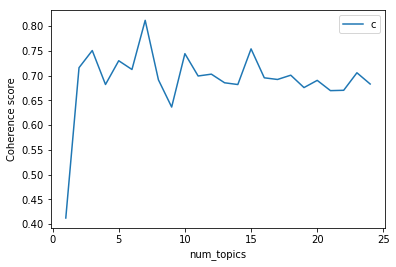

CPU times: user 43min 21s, sys: 3min 34s, total: 46min 56s
Wall time: 43min 51s


In [44]:
%%time
lmlist, c_v, best_model = evaluate_graph(dictionary=dictionary_filtered, corpus=corpus_filtered, texts=train_texts, limit=25)

In [45]:
print(c_v)
print(sorted(c_v.items(), key=operator.itemgetter(1), reverse=True)[0][0])

{0: 0.41248828214076794, 1: 0.71588236384310933, 2: 0.75049213038792273, 3: 0.68196747805544011, 4: 0.72988823484446097, 5: 0.7122324550313136, 6: 0.81142340282508052, 7: 0.69136633941977943, 8: 0.63642571727251707, 9: 0.74417090188046686, 10: 0.69910871685735143, 11: 0.70280784480000369, 12: 0.68539338889649914, 13: 0.6818787802440377, 14: 0.75384843806769875, 15: 0.69543778277843449, 16: 0.69208780748866616, 17: 0.70072335710062206, 18: 0.67571442165559481, 19: 0.6902570266578808, 20: 0.66955534536260775, 21: 0.67024285340412415, 22: 0.70560267335251414, 23: 0.68291809960977945}
6


In [1]:
pyLDAvis.gensim.prepare(lmlist[sorted(c_v.items(), key=operator.itemgetter(1), reverse=True)[0][0]], corpus_filtered, dictionary_filtered)

NameError: name 'pyLDAvis' is not defined

/media/discoD/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


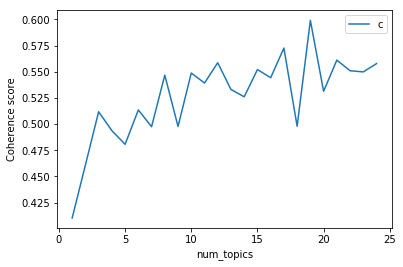

CPU times: user 3min 47s, sys: 9.62 s, total: 3min 56s
Wall time: 4min 16s


In [69]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary_filtered, corpus=corpus_filtered, texts=train_texts, limit=25)

In [71]:
print(c_v)
print(sorted(c_v.items(), key=operator.itemgetter(1), reverse=True)[0][0])
pyLDAvis.gensim.prepare(lmlist[sorted(c_v.items(), key=operator.itemgetter(1), reverse=True)[0][0]], corpus_filtered, dictionary_filtered)

{0: 0.41035927907250913, 1: 0.46093644691209118, 2: 0.51177747526663153, 3: 0.49375148748544218, 4: 0.48067385740298363, 5: 0.51349006758227378, 6: 0.49747281872569543, 7: 0.54669667617709161, 8: 0.49772471345661073, 9: 0.54872640906304715, 10: 0.53921368853885032, 11: 0.55852982984109001, 12: 0.53303247852220914, 13: 0.52602763502703387, 14: 0.55203572502128007, 15: 0.54425164773909984, 16: 0.57254704510380994, 17: 0.49791997085614448, 18: 0.59901722839556126, 19: 0.53128054208746278, 20: 0.56108379142957143, 21: 0.55090581366797342, 22: 0.54981089437012276, 23: 0.55772032930260285}
18


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      11.359927        1       1  0.000304  0.033858
10     11.245788        1       2  0.079002  0.081392
17      8.798475        1       3 -0.104924  0.007733
8       8.339230        1       4 -0.013342  0.001757
9       8.085767        1       5  0.069392 -0.033093
13      6.977408        1       6 -0.050719  0.024485
15      5.901448        1       7 -0.035346  0.005998
7       5.454372        1       8 -0.000406  0.041581
4       4.141544        1       9 -0.009137 -0.038885
5       3.889012        1      10  0.057237 -0.044278
0       3.612518        1      11  0.041302 -0.014186
11      3.356665        1      12  0.053649 -0.036352
12      3.330323        1      13  0.011570  0.016721
16      3.017919        1      14 -0.024820 -0.052733
6       2.912694        1      15  0.010926  0.010957
14      2.901187        1      16  0.029297  0.017425
18      2.664765        1      17 -0.063009  0.014753
2       2.093785        1      18 -0.007247  0.001368
1       1.917173        1      19 -0.043729 -0.038502, topic_info=     Category         Freq              Term        Total  loglift  logprob
term                                                                       
181   Default  1361.000000               www  1361.000000  30.0000  30.0000
182   Default  1185.000000               gov  1185.000000  29.0000  29.0000
87    Default  1659.000000              item  1659.000000  28.0000  28.0000
93    Default  1961.000000              ltda  1961.000000  27.0000  27.0000
26    Default  1732.000000            edital  1732.000000  26.0000  26.0000
1306  Default  1045.000000            código  1045.000000  25.0000  25.0000
186   Default   918.000000              site   918.000000  24.0000  24.0000
320   Default  2208.000000             valor  2208.000000  23.0000  23.0000
187   Default   582.000000        comprasnet   582.000000  22.0000  22.0000
184   Default   872.000000            propor   872.000000  21.0000  21.0000
6     Default  2346.000000           federal  2346.000000  20.0000  20.0000
481   Default  3773.000000               art  3773.000000  19.0000  19.0000
973   Default   789.000000             siape   789.000000  18.0000  18.0000
5514  Default   914.000000     uniformização   914.000000  17.0000  17.0000
278   Default  1678.000000              cnpj  1678.000000  16.0000  16.0000
279   Default  1174.000000         contratar  1174.000000  15.0000  15.0000
317   Default  2081.000000               lei  2081.000000  14.0000  14.0000
803   Default   283.000000              vaga   283.000000  13.0000  13.0000
53    Default  1105.000000            pregão  1105.000000  12.0000  12.0000
204   Default   520.000000          site_www   520.000000  11.0000  11.0000
2450  Default   834.000000             turma   834.000000  10.0000  10.0000
272   Default  1103.000000          contrato  1103.000000   9.0000   9.0000
89    Default  1278.000000           empresa  1278.000000   8.0000   8.0000
205   Default   374.000000    comprasnet_gov   374.000000   7.0000   7.0000
17    Default   802.000000             cargo   802.000000   6.0000   6.0000
172   Default  1282.000000             total  1282.000000   5.0000   5.0000
2638  Default   652.000000           decisão   652.000000   4.0000   4.0000
582   Default  1181.000000               ser  1181.000000   3.0000   3.0000
161   Default  1441.000000           serviço  1441.000000   2.0000   2.0000
316   Default  1185.000000             legal  1185.000000   1.0000   1.0000
...       ...          ...               ...          ...      ...      ...
184   Topic19    40.282964            propor   872.251518   0.8792  -5.1861
2679  Topic19     5.129793          advogado    60.067885   1.4939  -7.2469
188   Topic19    28.614946          abertura   591.843974   0.9250  -5.5281
199   Topic19    17.522698    licitar_edital   308.127846   1.0873  -6.0185
190   Topic

In [40]:
def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        lm = get_best_model_by_topics(corpus=corpus, dictionary=dictionary, limit=50, texts=train_texts)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=train_texts, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
        print('Melhores 5 modelos', top_topics[:5])
    return lm, top_topics

In [36]:
logging.disable(level=logging.INFO)

In [41]:
%%time
lm, top_topics = ret_top_model()

/home/pedro/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


Melhores 5 modelos [(5, 0.73169988798851271), (6, 0.71814579497499709), (3, 0.70086624055723812), (8, 0.69283338471343381), (16, 0.69105868521961733)]
Melhores 5 modelos [(1, 0.49153038747834793), (3, 0.44309482355181345), (0, 0.43110158015085565), (2, 0.40061933994606369), (4, 0.3110018845401829)]
Melhores 5 modelos [(4, 0.69710422491541302), (6, 0.69404891378665534), (8, 0.68678316062030731), (11, 0.67126412647894373), (5, 0.66767950243178775)]
Melhores 5 modelos [(0, 0.4885467543531396), (4, 0.41963539439982139), (2, 0.40061933994606358), (1, 0.35394331687792369), (3, 0.26719702343250151)]
Melhores 5 modelos [(6, 0.7830594008182562), (4, 0.71760172308584602), (11, 0.68522395617128784), (10, 0.67995211597921457), (5, 0.65671638010587141)]
Melhores 5 modelos [(1, 0.56142051842803409), (0, 0.44998082398855033), (3, 0.40061933994606358), (5, 0.36856048288168497), (2, 0.28381836930200388)]
Melhores 5 modelos [(8, 0.71590185433575781), (7, 0.71514098432779905), (6, 0.70801810375746099), (

KeyboardInterrupt: 

In [35]:
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:10]])

[[('proc_adv', 0.016016731893559868),
  ('incidente_uniformizacao', 0.012829814647509962),
  ('turma_recursal', 0.010936625295985868),
  ('inss_proc', 0.0091306983065047899),
  ('adv_procuradoria', 0.0090731010745261562),
  ('geral_federal', 0.0090731010745261562),
  ('parte_ora', 0.0089602210762516534),
  ('trata_agravo', 0.0087707625168775873),
  ('decisao_inadmitiu', 0.0086072663449699785),
  ('oab_requerido', 0.0083177163107341027)],
 [('comprasnet_gov', 0.027017224699846496),
  ('site_www', 0.02529700182894204),
  ('objeto_pregao', 0.018273239373618657),
  ('processo', 0.017400868819024449),
  ('abertura_propostas', 0.016551539482735283),
  ('propostas_partir', 0.016024489602518018),
  ('total_itens', 0.015450838906475283),
  ('edital_entrega', 0.01466498751076112),
  ('www_gov', 0.014505528771094914),
  ('licitados_edital', 0.01427815875000788)],
 [('codigo', 0.0098117947182114144),
  ('turma_recursal', 0.0092078500893413729),
  ('proc_adv', 0.0080897032116355461),
  ('incidente_

In [43]:
pyLDAvis.gensim.prepare(lm, corpus,       dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
4      5.002951        1       1 -0.390125 -0.036099
5      3.575705        1       2 -0.022637  0.180683
24     2.477793        1       3  0.070474 -0.029306
36     2.476030        1       4  0.018813  0.117893
72     2.272221        1       5  0.101304  0.005740
29     2.040274        1       6  0.096014 -0.055481
10     2.015970        1       7  0.034471 -0.017698
33     1.997512        1       8 -0.352434 -0.010864
76     1.812089        1       9  0.034875  0.042069
48     1.639230        1      10 -0.290535  0.037545
96     1.590694        1      11  0.071052 -0.017431
13     1.546939        1      12 -0.055480  0.005160
20     1.542378        1      13  0.061909  0.015141
78     1.526152        1      14  0.025200  0.002911
95     1.497165        1      15  0.064531 -0.012988
73     1.495734        1      16  0.016071  0.017601
85     1.432516        1      17  0.081672 -0.009027
8      1.396610        1      18 -0.280899  0.052196
46     1.390328        1      19  0.075234  0.148496
92     1.364753        1      20 -0.034771 -0.045221
63     1.350009        1      21  0.071802  0.019641
12     1.340904        1      22 -0.038872 -0.050807
15     1.314007        1      23  0.086328 -0.046006
83     1.296976        1      24  0.097731 -0.078775
55     1.276031        1      25 -0.172338  0.085062
31     1.249677        1      26  0.022550  0.039066
56     1.177628        1      27 -0.057871 -0.025176
90     1.165912        1      28  0.072910 -0.068320
47     1.158943        1      29  0.026099  0.115509
93     1.130407        1      30 -0.024427 -0.090750
...         ...      ...     ...       ...       ...
17     0.623098        1      71  0.068399  0.061484
39     0.611907        1      72 -0.008856  0.020029
40     0.599354        1      73  0.052906 -0.105208
97     0.578776        1      74  0.077977 -0.023870
57     0.552933        1      75  0.028425 -0.049248
58     0.552239        1      76 -0.019148 -0.091558
70     0.544983        1      77  0.084248  0.049683
7      0.544079        1      78 -0.120277 -0.099871
77     0.536104        1      79  0.034853 -0.021374
61     0.533028        1      80 -0.009357  0.045906
52     0.527977        1      81  0.030299  0.061488
38     0.517422        1      82 -0.013804  0.082175
79     0.505000        1      83 -0.145423  0.083312
18     0.490175        1      84 -0.052268 -0.078556
66     0.482309        1      85 -0.008728  0.021974
2      0.469946        1      86  0.033046  0.041294
9      0.462770        1      87 -0.183742  0.020642
25     0.443844        1      88  0.042634 -0.040058
11     0.432519        1      89  0.052711 -0.026380
37     0.432399        1      90  0.054880 -0.002248
87     0.432293        1      91  0.083387 -0.016078
0      0.426041        1      92  0.040855 -0.068819
30     0.413210        1      93 -0.041688 -0.027159
75     0.407997        1      94 -0.009008 -0.066735
91     0.401531        1      95  0.000840 -0.051953
82     0.396238        1      96  0.009260  0.087013
89     0.388531        1      97  0.039328 -0.077704
35     0.378135        1      98  0.045841  0.014267
32     0.285215        1      99  0.008807  0.011213
81     0.260842        1     100 -0.028100 -0.032002

[100 rows x 5 columns], topic_info=       Category         Freq                        Term        Total  \
term                                                                    
13572   Default   435.000000                  vigor_data   435.000000   
7919    Default   304.000000              quadro_pessoal   304.000000   
63      Default  1011.000000                        item  1011.000000   
583     Default  1776.000000                         art  1776.000000   
2767    Default   637.000000                      codigo   637.000000   
14098   Default   254.000000                 resolve_art   254.000000   
6561    De